In [1]:
device = 'mps'


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import tqdm as tqdm


In [17]:
train_dataset = torchvision.datasets.QMNIST('data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.QMNIST('data', train=False, download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training with {len(train_dataset)} samples")
print(f"Testing with {len(test_dataset)} samples")


Training with 60000 samples
Testing with 60000 samples


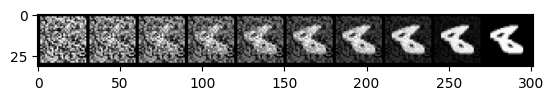

In [4]:
import math
def noiser(img, steps):
    noise = torch.rand_like(img)
    noise_scale = lambda s: 1 - (s / (steps-1))
    noisy_imgs = [
        img * (1 - noise_scale(s)) + noise * noise_scale(s) for s in range(steps)
    ]
    return noisy_imgs

x, y = next(iter(train_loader))
imgs = noiser(x[0], 10)
grid = torchvision.utils.make_grid(imgs, nrow=10)
plt.imshow(grid.permute(1, 2, 0))
plt.show()


In [23]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.BatchNorm1d(28 * 28 * 2)
        self.fc1 = nn.Linear(28 * 28 *2, 256)
        self.b2 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.b3 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 256)
        self.b4 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 28 * 28)
        
        self.class_embedding = nn.Embedding(10, 28 * 28)
        self.time_embedding = nn.Embedding(1, 28 * 28)
        
    def forward(self, x, y, t):
        t = torch.tensor(t).to(device)
        x = x.view(x.size(0), -1)
        y = self.class_embedding(y)
        t = self.time_embedding(t)
        x = x + t
        x = torch.cat([x, y], dim=1)
        
        x1 = self.b1(x)
        x1 = F.relu(self.fc1(x1))
        x2 = self.b2(x1)
        x2 = F.relu(self.fc2(x2))
        x3 = self.b3(x2)
        x3 = F.relu(self.fc3(x3 + x2))
        x4 = self.b4(x3 + x1)
        x4 = F.sigmoid(self.fc4(x4 + x1))
        
        return x4
        
model = Model().to(device)


criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

stats = {
    "train_loss": [],
    "test_loss": [],
    "test_accuracy": [],
}

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")


Model has 682,112 parameters


In [24]:
def generate(model, noise, steps, classes=None):
    if classes is None:
        classes = torch.randint(0, 10, (noise.size(0),)).to(noise.device)
    with torch.no_grad():
        for s in range(steps):
            noise = model(noise.view(-1, 28*28), classes, s)
    return noise


In [28]:
for epoch in range(10):
    model.train()
 
    with tqdm.tqdm(total=len(train_loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{10}")
        
        for x, y in train_loader:
            tq.update(1)
            x, y = x.to(device), y.to(device)
            total_loss = 0
            
            noisy_imgs = noiser(x, 10)
            optimizer.zero_grad()
            for t, (sample, target) in enumerate(zip(noisy_imgs, noisy_imgs[1:])):
                
                pred = model(sample.view(-1, 28*28), y, t)
                loss = criterion(pred, target.view(-1, 28*28))
                
                total_loss += loss
                                
            total_loss.backward()
            optimizer.step()
                
            tq.set_postfix_str(f"Loss: {total_loss:.4f}")
                
        with torch.no_grad():
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            x, y = next(iter(test_loader))
            x, y = x.to(device), y.to(device)
            noise = noiser(x, 190)
            output = generate(model, noise[0], 10, y)
            grid = torchvision.utils.make_grid(output.view(-1, 1, 28, 28), nrow=8).cpu()
            plt.imshow(grid.permute(1, 2, 0))
            plt.title("Reconstructed")
            plt.axis('off')
                
            plt.subplot(1, 2, 2)
            noise = torch.rand_like(x)
            generated = generate(model, noise, 10)
            grid = torchvision.utils.make_grid(generated.view(-1, 1, 28, 28), nrow=8).cpu()
            plt.imshow(grid.permute(1, 2, 0))
            plt.title("Noise")
            plt.axis('off')
            plt.show()


Train :: Epoch: 0/10:  32%|███▏      | 301/938 [00:15<00:32, 19.73it/s, Loss: 0.4600]


KeyboardInterrupt: 

In [26]:
print(model)


Model(
  (b1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (b2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (b3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (b4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
  (class_embedding): Embedding(10, 784)
  (time_embedding): Embedding(1, 784)
)


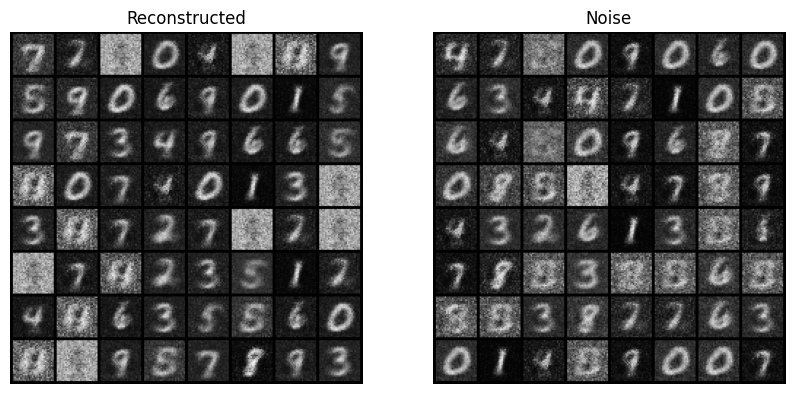

In [27]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)
noise = noiser(x, 10)
output = generate(model, noise[0], 10, y)
grid = torchvision.utils.make_grid(output.view(-1, 1, 28, 28), nrow=8).cpu()
plt.imshow(grid.permute(1, 2, 0))
plt.title("Reconstructed")
plt.axis('off')
    
plt.subplot(1, 2, 2)
noise = torch.rand_like(x)
generated = generate(model, noise, 10)
grid = torchvision.utils.make_grid(generated.view(-1, 1, 28, 28), nrow=8).cpu()
plt.imshow(grid.permute(1, 2, 0))
plt.title("Noise")
plt.axis('off')
plt.show()
